## Initialisation 

In [363]:
#Declaring imports
import csv
import os
import pandas as pd
import xgboost as xgb

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.cross_validation import KFold
from sklearn.metrics import classification_report
import xgboost as xgd


In [364]:
DEBUGGING = True

In [365]:
#Files
train_data_path = '../input/train.csv'
test_data_path = '../input/test.csv'


In [366]:
train_df = pd.read_csv(train_data_path)
test_df = pd.read_csv(test_data_path)


In [367]:
#Partitions the training data for test and training because only training will show results
if DEBUGGING:
    partition = 0.9 * train_df.shape[0]
    test_df = train_df.loc[partition:, ]
    train_df = train_df.loc[:partition,]


In [368]:
print("DEBUGGING: {}".format(DEBUGGING))
print(train_df.shape)
print(test_df.shape)

DEBUGGING: True
(802, 12)
(89, 12)


In [369]:
all_data = [train_df, test_df]

In [370]:
#Renaming columns so its easier to understand
for dataset in all_data:
    dataset.rename(inplace=True, columns={'PassengerId':'Id', 'Pclass':'TicketClass', 'SibSp':'NumSiblingsSpouse', 'Parch':'NumParentsChild', 'ticket':'TicketNumber', 'Cabin':'CabinNumber', 'embarked':'PortEmbarked'})

# Exploratory Data Analysis
Seeing the rough distribution of the different columns

In [371]:
#Seeing how the dataframe is like
train_df.describe()

,Id,Survived,TicketClass,Age,NumSiblingsSpouse,NumParentsChild,Fare
count,802.000000,802.000000,802.000000,639.000000,802.000000,802.000000,802.000000
mean,401.500000,0.385287,2.304239,29.879374,0.518703,0.374065,33.005086
std,231.661751,0.486967,0.835963,14.522473,1.062480,0.800889,51.466003
min,1.000000,0.000000,1.000000,0.670000,0.000000,0.000000,0.000000
25%,201.250000,0.000000,2.000000,21.000000,0.000000,0.000000,7.925000
50%,401.500000,0.000000,3.000000,28.000000,0.000000,0.000000,14.500000
75%,601.750000,1.000000,3.000000,38.000000,1.000000,0.000000,31.206250
max,802.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


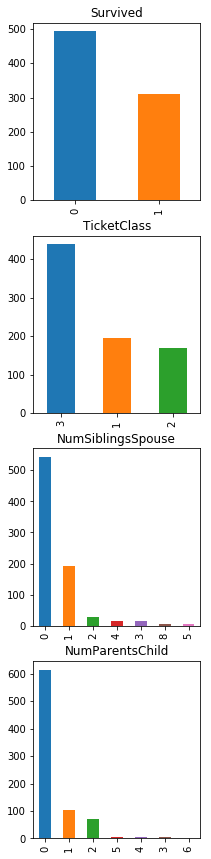

In [372]:
#Seeing the distribution of discrete data
col_list =  ['Survived', 'TicketClass', 'NumSiblingsSpouse', 'NumParentsChild']
fig, axes = plt.subplots(nrows=len(col_list), ncols=1, figsize=(3,15))
for i, col_name in enumerate(col_list):
    train_df[col_name].value_counts().plot(kind='bar', ax=axes[i], title = col_name)


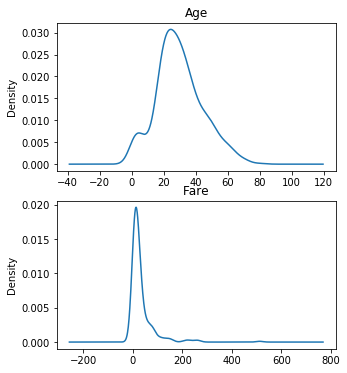

In [373]:
#Plotting continuous distributions
col_list = ['Age', 'Fare']
fig, axes = plt.subplots(nrows=len(col_list), ncols=1, figsize=(5,6))
for i, col_name in enumerate(col_list):
    train_df[col_name].plot(kind='density', ax=axes[i], title = col_name)


In [374]:
#Finding the number of null values in each column to see which column has a problem
results = {}
vals = {}
for key in train_df.keys():
    vals[key] = train_df[key].isnull().sum()
results['train'] = vals

vals = {}
for key in test_df.keys():
    vals[key] = test_df[key].isnull().sum()
results['test'] = vals
pd.DataFrame.from_dict(results, dtype=int)

,train,test
Age,163,14
CabinNumber,617,70
Embarked,1,1
Fare,0,0
Id,0,0
Name,0,0
NumParentsChild,0,0
NumSiblingsSpouse,0,0
Sex,0,0
Survived,0,0


## Seeing how the different features affect outcome

In [375]:
print(train_df[['TicketClass','Survived']].groupby(['TicketClass']).mean())

             Survived
TicketClass          
1            0.615385
2            0.482143
3            0.246014


In [376]:
print(train_df[["Sex", "Survived"]].groupby(['Sex']).mean())

        Survived
Sex             
female  0.746479
male    0.187259


In [377]:
print(train_df[["Sex","Survived"]].groupby(["Sex"]).mean())

        Survived
Sex             
female  0.746479
male    0.187259


In [378]:
for dataset in all_data:
    dataset["FamilySize"] = dataset["NumSiblingsSpouse"] + dataset["NumParentsChild"] + 1
print (train_df[['FamilySize', 'Survived']].groupby(['FamilySize']).mean())

            Survived
FamilySize          
1           0.311203
2           0.530612
3           0.565217
4           0.730769
5           0.200000
6           0.157895
7           0.400000
8           0.000000
11          0.000000


In [379]:
for dataset in all_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
print (train_df[['IsAlone', 'Survived']].groupby(['IsAlone']).mean())

         Survived
IsAlone          
0        0.496875
1        0.311203


## Handling NA values

In [380]:
#Drop if more than a number of NA values
for dataset in all_data:
    length = len(dataset.keys())
    dataset.dropna(thresh=length-5, inplace=True)

In [381]:
#Drop the rows with NA values in embarked 
for dataset in all_data:
    dataset.dropna(subset=['Embarked'],inplace=True)

In [382]:
#There are quite alot of null values in age and cabin, so I will replace them with the most frequently occuring values
for dataset in all_data:
    dataset['Fare'] = dataset['Fare'].fillna(train_df['Fare'].median())
    dataset['Age'] = dataset['Age'].fillna(train_df['Age'].median())
    dataset['Embarked'] = dataset['Embarked'].fillna('C')

In [383]:
for dataset in all_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] 						        = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] 							        = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4 ;

In [384]:
if DEBUGGING:
    test_y = test_df["Survived"]
    test_df.drop("Survived", axis=1, inplace=True)


In [385]:
print("DEBUGGING: {}".format(DEBUGGING))
print(train_df.shape)
print(test_df.shape)

DEBUGGING: True
(801, 14)
(88, 13)


In [386]:
PassengerId = test_df['Id']

# Feature Selection

In [387]:
drop_elements = ['Id', 'Name', 'Ticket', 'CabinNumber', 'NumSiblingsSpouse']
for dataset in all_data:
    dataset.drop(drop_elements, axis=1, inplace=True)

# More Visualisation

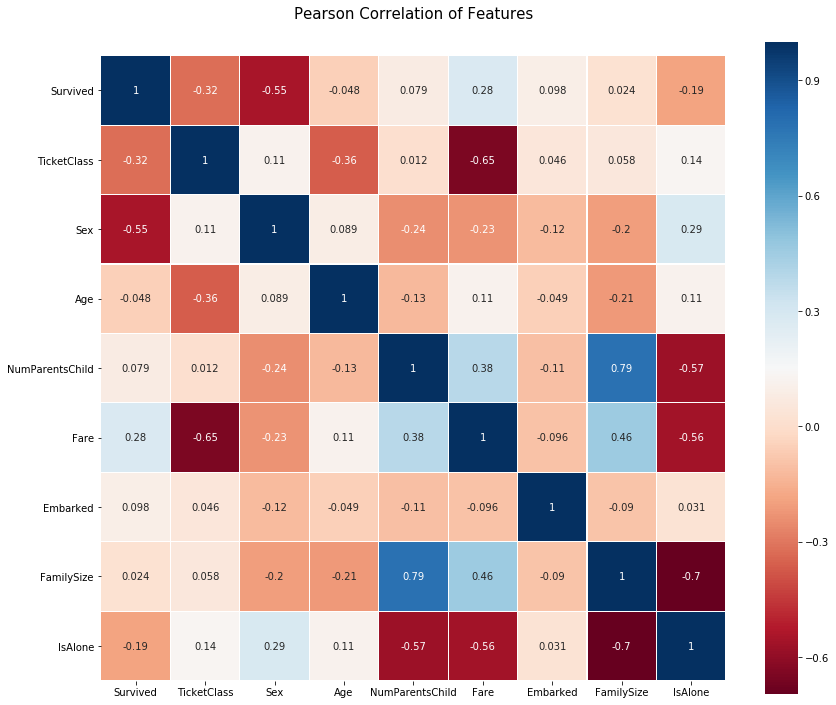

In [388]:
#Understanding correlation will help in deciding which features are important and which are not
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train_df.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)


In [389]:
# Initialising variables to be used for model

In [390]:
n_train = train_df.shape[0]
n_test = test_df.shape[0]
SEED = 0
NFOLDS = 5
kf = KFold(n_train, n_folds = NFOLDS, random_state=SEED)

In [391]:
class SklearnHelper:
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)
    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)
    def predict(self, x):
        return self.clf.predict(x)
    def fit(self, x, y):
        return self.clf.fit(x,y)
    def feature_importances(self, x, y):
        return self.clf.fit(x,y).feature_importances_

In [392]:
#Performs out-of-fold cross validation
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((n_train,))
    oof_test = np.zeros((n_test,))
    oof_test_skf = np.empty((NFOLDS, n_test))

    for i, (train_index, test_index) in enumerate(kf):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [393]:
# Put in our parameters for said classifiers
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 10,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 10,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 10,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.1
    }

In [394]:
# Create 5 objects that represent our 5 models
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)


In [395]:
# Create Numpy arrays of train, test and target ( Survived) dataframes to feed into our models
y_train = train_df['Survived'].ravel()
train = train_df.drop(['Survived'], axis=1)
x_train = train.values # Creates an array of the train_df data
x_test = test_df.values # Creats an array of the test_df data

In [396]:
# Create our OOF train and test predictions. These base results will be used as new features
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test) # Support Vector Classifier

print("Training is complete")

/anaconda/envs/tensorflow/lib/python3.6/site-packages/sklearn/ensemble/forest.py:305: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "


Training is complete


In [397]:
et_features = et.feature_importances(x_train, y_train)
rf_features = rf.feature_importances(x_train, y_train)
ada_features = ada.feature_importances(x_train, y_train)
gb_features = gb.feature_importances(x_train, y_train)

/anaconda/envs/tensorflow/lib/python3.6/site-packages/sklearn/ensemble/forest.py:305: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "


In [398]:
cols = train.columns.values
# Create a dataframe with features
feature_dataframe = pd.DataFrame.from_dict( {
     'Random Forest feature importances': rf_features,
     'Extra Trees  feature importances': et_features,
      'AdaBoost feature importances': ada_features,
    'Gradient Boost feature importances': gb_features
    }, orient='index').transpose()

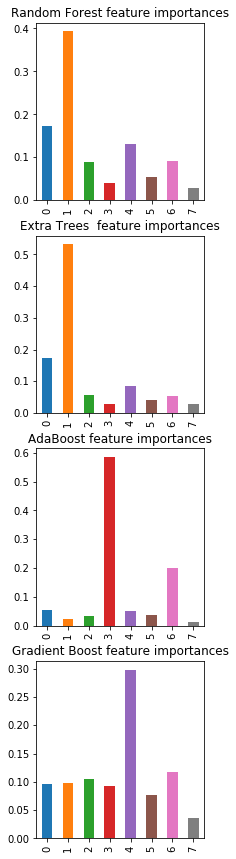

In [399]:
fig, axes = plt.subplots(nrows=len(feature_dataframe.keys()), ncols=1, figsize=(3,15))
for i, key in enumerate(feature_dataframe.keys()):
    feature_dataframe[key].plot(kind='bar',ax=axes[i], title=key)

## As we can see, the different models have different features that are prioritised

In [400]:
base_predictions_train = pd.DataFrame( {'RandomForest': rf_oof_train.ravel(),
     'ExtraTrees': et_oof_train.ravel(),
     'AdaBoost': ada_oof_train.ravel(),
      'GradientBoost': gb_oof_train.ravel()
    })

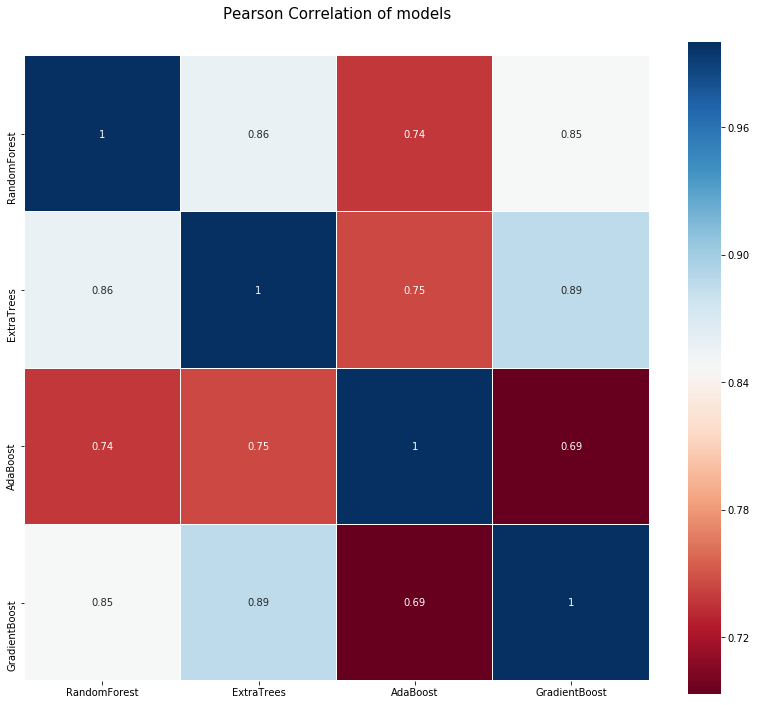

In [401]:

#Understanding correlation will help in deciding which features are important and which are not
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of models', y=1.05, size=15)
sns.heatmap(base_predictions_train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

# Second level xgboosting

In [402]:
x_train = np.concatenate(( et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis=1)
x_test = np.concatenate(( et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis=1)

In [403]:
gbm = xgb.XGBClassifier(
    #learning_rate = 0.02,
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(x_train, y_train)
predictions = gbm.predict(x_test)

/anaconda/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [404]:
#If debugging, show the optimal test report
if DEBUGGING:
    print(classification_report(test_y, predictions))

             precision    recall  f1-score   support

          0       0.85      0.91      0.88        56
          1       0.82      0.72      0.77        32

avg / total       0.84      0.84      0.84        88



In [405]:
# Generate Submission File 
StackingSubmission = pd.DataFrame({ 'PassengerId': PassengerId,
                            'Survived': predictions })
StackingSubmission.to_csv("StackingSubmission.csv", index=False)

In [406]:
predictions.shape

(88,)